# Imports & Setup

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import Union, Optional
from functools import lru_cache

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('pastel')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Constants
CSV_URL = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSpDvv8U_cvnLpnsIeUBlfDWASfQfKdwJz_cfkh6wGwFjRtKhmlFGOkI9UvHcFS04YElvx-N5FZhV-U/pub?gid=1041973731&single=true&output=csv"

# Data Loading

In [244]:
def load_data(url: str) -> pd.DataFrame:
    """Load data from URL and return cleaned DataFrame.

    Args:
        url: URL to CSV data

    Returns:
        pandas DataFrame with cleaned column names
    """
    try:
        df = pd.read_csv(url)
        # Clean column names
        df.columns = [re.sub(r'\W+', '_', col.lower().strip()) for col in df.columns]
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load and verify data
data = load_data(CSV_URL)
print(f"Data loaded with shape: {data.shape}")
data.head()

Data loaded with shape: (493, 11)


,dbn,school_name,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,sat_critical_readng_avg_score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,377,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,414,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,390,672714,x123,92%,2.0


# Data Exploring

In [245]:
'''
- Make all lowercase
- Replace spaces with underscores (_)
- Remove special characters
'''
import re

# Clean column names
data.columns = [
    re.sub(r'\W+', '_', col.lower().strip())
    for col in data.columns
]
data.columns

Index(['dbn', 'school_name', 'num_of_sat_test_takers',
       'sat_critical_reading_avg_score', 'sat_math_avg_score',
       'sat_writing_avg_score', 'sat_critical_readng_avg_score',
       'internal_school_id', 'contact_extension', 'pct_students_tested',
       'academic_tier_rating'],
      dtype='object')

In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dbn                             493 non-null    object 
 1   school_name                     493 non-null    object 
 2   num_of_sat_test_takers          493 non-null    object 
 3   sat_critical_reading_avg_score  493 non-null    object 
 4   sat_math_avg_score              493 non-null    object 
 5   sat_writing_avg_score           493 non-null    object 
 6   sat_critical_readng_avg_score   493 non-null    object 
 7   internal_school_id              493 non-null    int64  
 8   contact_extension               388 non-null    object 
 9   pct_students_tested             376 non-null    object 
 10  academic_tier_rating            402 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 42.5+ KB


In [247]:
data.head()

,dbn,school_name,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,sat_critical_readng_avg_score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,377,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,414,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,390,672714,x123,92%,2.0


In [248]:
data.drop(columns=['sat_critical_readng_avg_score'], inplace=True)

In [249]:
data.columns

Index(['dbn', 'school_name', 'num_of_sat_test_takers',
       'sat_critical_reading_avg_score', 'sat_math_avg_score',
       'sat_writing_avg_score', 'internal_school_id', 'contact_extension',
       'pct_students_tested', 'academic_tier_rating'],
      dtype='object')

In [250]:
data[data.duplicated(subset=data.columns)].count()

,0
dbn,15
school_name,15
num_of_sat_test_takers,15
sat_critical_reading_avg_score,15
sat_math_avg_score,15
sat_writing_avg_score,15
internal_school_id,15
contact_extension,10
pct_students_tested,13
academic_tier_rating,10


In [251]:
data.drop_duplicates(subset=data.columns, inplace=True)
data.describe()

,internal_school_id,academic_tier_rating
count,478.000000,392.000000
mean,560082.717573,2.579082
std,259637.064755,1.128053
min,101855.000000,1.000000
25%,337012.500000,2.000000
50%,581301.500000,3.000000
75%,778312.750000,4.000000
max,999398.000000,4.000000


In [252]:
data.columns

Index(['dbn', 'school_name', 'num_of_sat_test_takers',
       'sat_critical_reading_avg_score', 'sat_math_avg_score',
       'sat_writing_avg_score', 'internal_school_id', 'contact_extension',
       'pct_students_tested', 'academic_tier_rating'],
      dtype='object')

# Data Cleaning

## num_of_sat_test_takers

In [253]:
data['num_of_sat_test_takers'].value_counts(dropna=False)

,count
num_of_sat_test_takers,
s,57
54,10
48,8
72,8
9,8
...,...
807,1
535,1
227,1


In [254]:
data[data['num_of_sat_test_takers']=='s']['num_of_sat_test_takers'].count()

np.int64(57)

In [255]:
data['num_of_sat_test_takers'] = data['num_of_sat_test_takers'].astype(str)

In [256]:
data['num_of_sat_test_takers'].replace('s', np.nan, inplace=True)
data['num_of_sat_test_takers'] = data['num_of_sat_test_takers'].astype('Int64')

/tmp/ipython-input-1184036537.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['num_of_sat_test_takers'].replace('s', np.nan, inplace=True)


<Axes: >

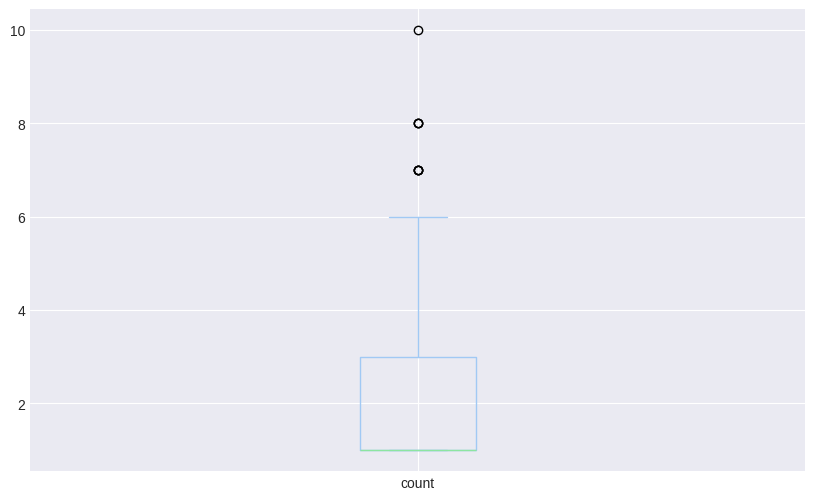

In [257]:
data['num_of_sat_test_takers'].value_counts(dropna=True).sort_index().plot(kind='box')

<Axes: ylabel='Frequency'>

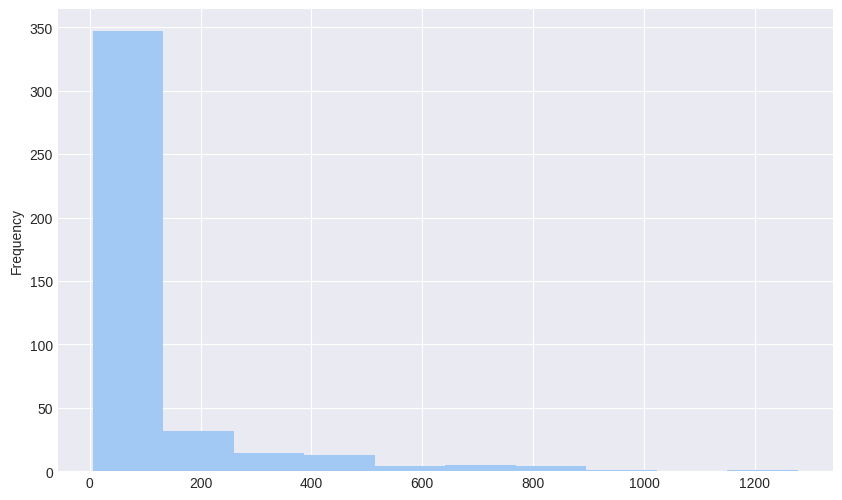

In [258]:
data['num_of_sat_test_takers'].plot(kind='hist')

In [259]:
mean_val = int (data['num_of_sat_test_takers'].mean())
mean_val

110

In [260]:
data['num_of_sat_test_takers'].isna().sum()

np.int64(57)

In [261]:
data['num_of_sat_test_takers'].value_counts(dropna=False)

,count
num_of_sat_test_takers,
<NA>,57
54,10
72,8
9,8
48,8
...,...
271,1
535,1
227,1


In [262]:
data['num_of_sat_test_takers'].fillna(mean_val, inplace=True)

<Axes: ylabel='Frequency'>

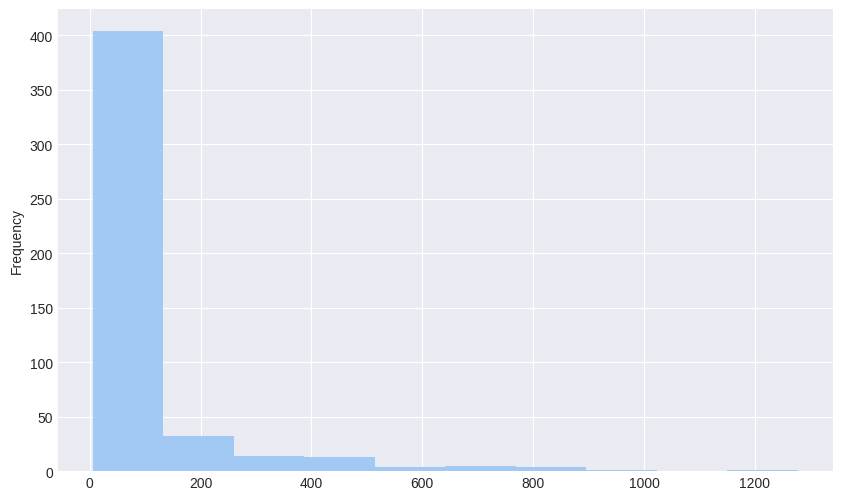

In [263]:
data['num_of_sat_test_takers'].plot(kind='hist')

## sat_critical_reading_avg_score

In [264]:
data['sat_critical_reading_avg_score'].value_counts(dropna=False)

,count
sat_critical_reading_avg_score,
s,57
367,8
384,8
370,8
398,8
...,...
472,1
437,1
466,1


In [265]:
data['sat_critical_reading_avg_score'].replace('s', np.nan, inplace=True)
data['sat_critical_reading_avg_score'] = data['sat_critical_reading_avg_score'].astype('Int64')
data['sat_critical_reading_avg_score'].value_counts(dropna=False)

/tmp/ipython-input-2021591839.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sat_critical_reading_avg_score'].replace('s', np.nan, inplace=True)


,count
sat_critical_reading_avg_score,
<NA>,57
384,8
370,8
367,8
398,8
...,...
487,1
437,1
466,1


<Axes: >

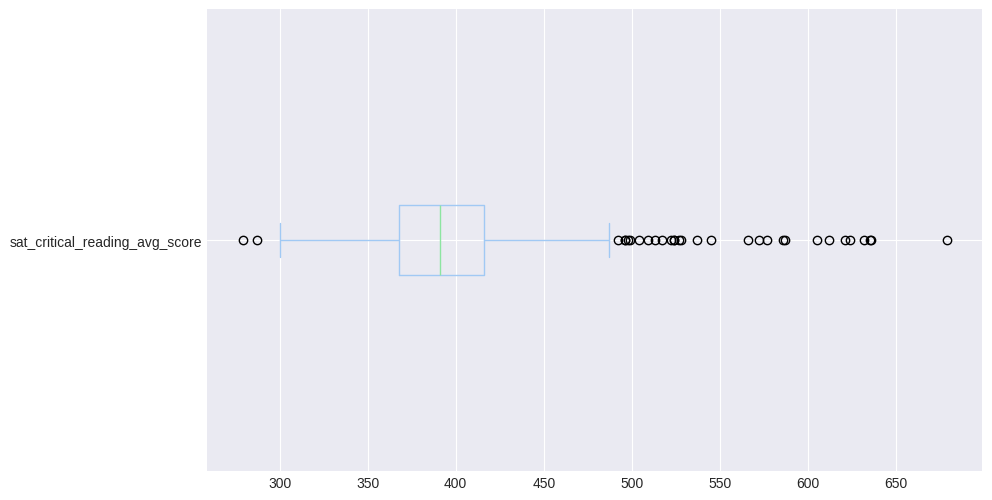

In [266]:
data['sat_critical_reading_avg_score'].plot(kind='box', vert=False)

In [267]:
mean_val = int (data['sat_critical_reading_avg_score'].mean())
mean_val

400

In [268]:
data['sat_critical_reading_avg_score'].isna().sum()

np.int64(57)

In [269]:
data['sat_critical_reading_avg_score'].fillna(mean_val, inplace=True)

<Axes: >

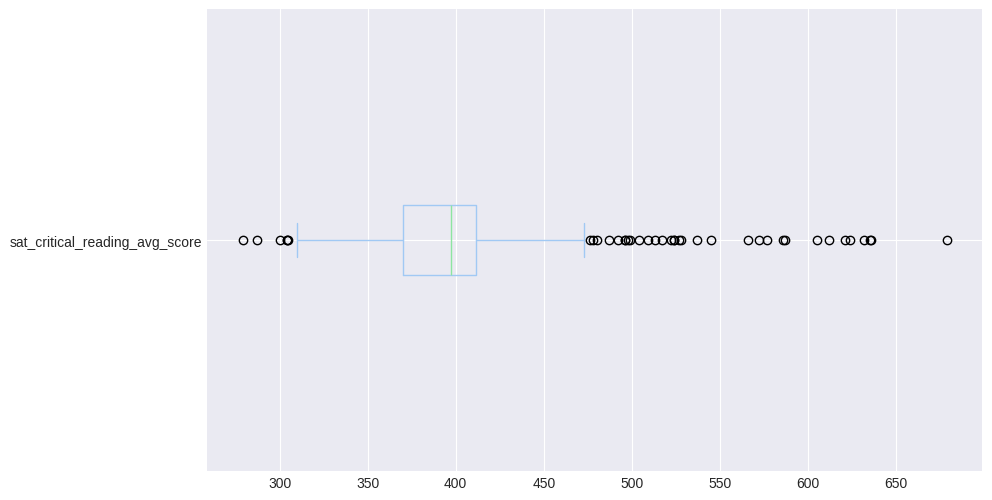

In [270]:
data['sat_critical_reading_avg_score'].plot(kind='box', vert=False)

## sat_math_avg_score

In [271]:
data['sat_math_avg_score'].value_counts(dropna=False)

,count
sat_math_avg_score,
s,57
385,9
381,8
371,8
364,8
...,...
1100,1
488,1
682,1


In [272]:
data['sat_math_avg_score'].replace('s', np.nan, inplace=True)
data['sat_math_avg_score'] = data['sat_math_avg_score'].astype('Int64')

/tmp/ipython-input-3864702484.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sat_math_avg_score'].replace('s', np.nan, inplace=True)


In [273]:
data['sat_math_avg_score'].value_counts(dropna=False)

,count
sat_math_avg_score,
<NA>,57
385,9
381,8
364,8
371,8
...,...
660,1
488,1
682,1


418

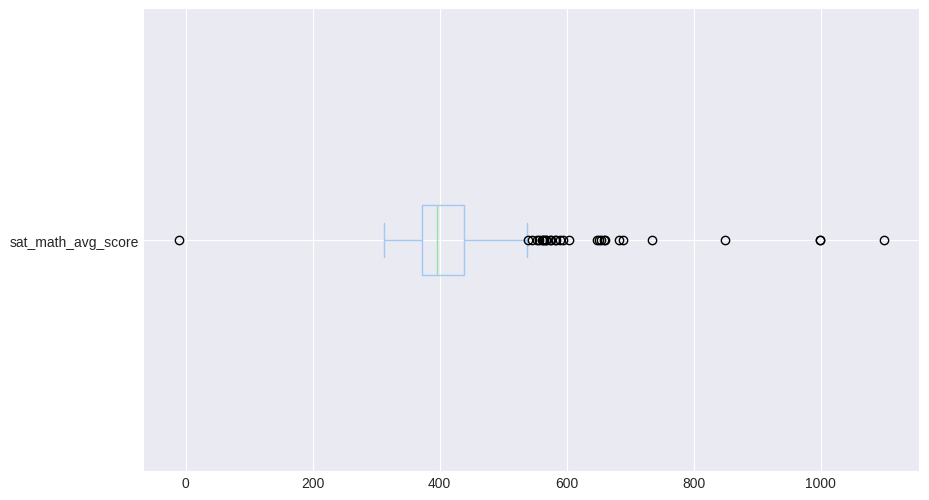

In [274]:
data['sat_math_avg_score'].plot(kind='box', vert=False)
mean_val = int (data['sat_math_avg_score'].mean())
mean_val


In [275]:
data['sat_math_avg_score'].isna().sum()

np.int64(57)

In [276]:
data['sat_math_avg_score'].fillna(mean_val, inplace=True)

<Axes: >

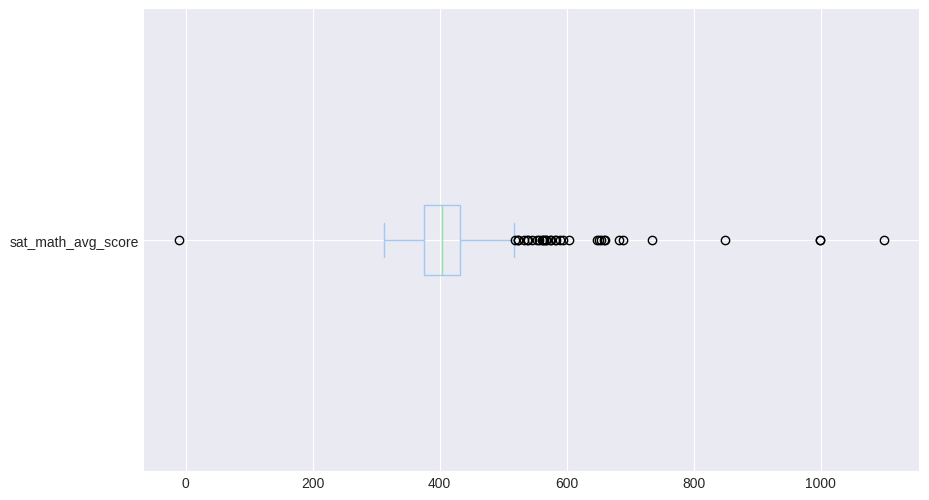

In [277]:
data['sat_math_avg_score'].plot(kind='box', vert=False)

## sat_writing_avg_score

In [278]:
data['sat_writing_avg_score'].value_counts(dropna=False)

,count
sat_writing_avg_score,
s,57
370,9
368,9
394,8
359,8
...,...
466,1
417,1
470,1


In [279]:
data['sat_writing_avg_score'].replace('s', np.nan, inplace=True)
data['sat_writing_avg_score'] = data['sat_writing_avg_score'].astype('Int64')
data['sat_writing_avg_score'].value_counts(dropna=False)

/tmp/ipython-input-2963302029.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sat_writing_avg_score'].replace('s', np.nan, inplace=True)


,count
sat_writing_avg_score,
<NA>,57
368,9
370,9
394,8
359,8
...,...
450,1
417,1
470,1


<Axes: >

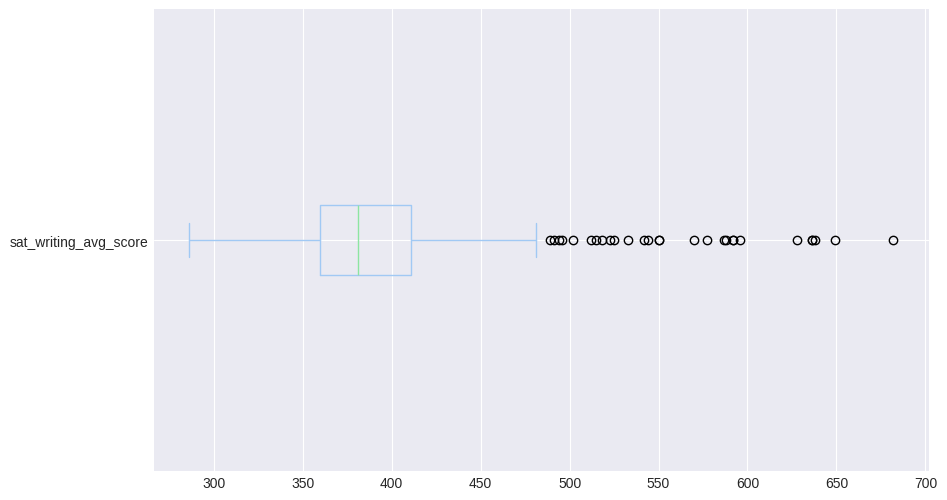

In [280]:
data['sat_writing_avg_score'].plot(kind='box', vert=False)

In [281]:
mean_val = int (data['sat_writing_avg_score'].mean())
mean_val

393

In [282]:
data['sat_writing_avg_score'].isna().sum()

np.int64(57)

In [283]:
data['sat_writing_avg_score'].fillna(mean_val, inplace=True)

<Axes: >

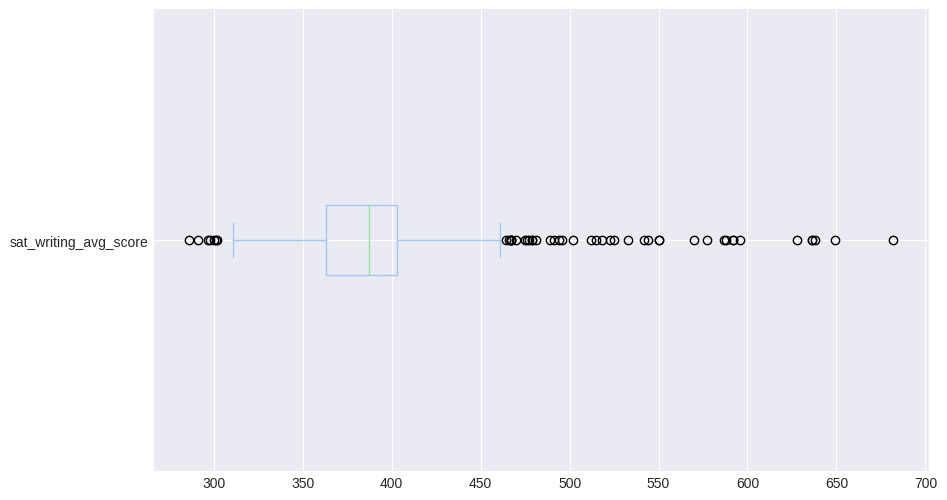

In [284]:
data['sat_writing_avg_score'].plot(kind='box', vert=False)

## Outliers Removal in Scores

In [285]:
score_cols = ['sat_math_avg_score', 'sat_critical_reading_avg_score', 'sat_writing_avg_score']
test_data = data.copy()
test_data= test_data[(test_data[score_cols]>200).all(axis=1) & (test_data[score_cols]<800).all(axis=1)]

In [286]:
len(data) - len(test_data)

5

In [287]:
def compare_both_boxes(df1, df2, cols):
  indexes = len(cols) * 2
  fig, axes = plt.subplots (indexes, 1)
  for col in cols:
    i = cols.index(col)
    axes[i*2].set_title (f"data with outliers [{col}]")
    df1[col].plot(kind='box', vert=False, ax=axes[i*2])
    axes[i*2+1].set_title (f"data with removed outliers [{col}]")
    df2[col].plot(kind='box', vert=False, ax=axes[i*2+1])
  plt.tight_layout()



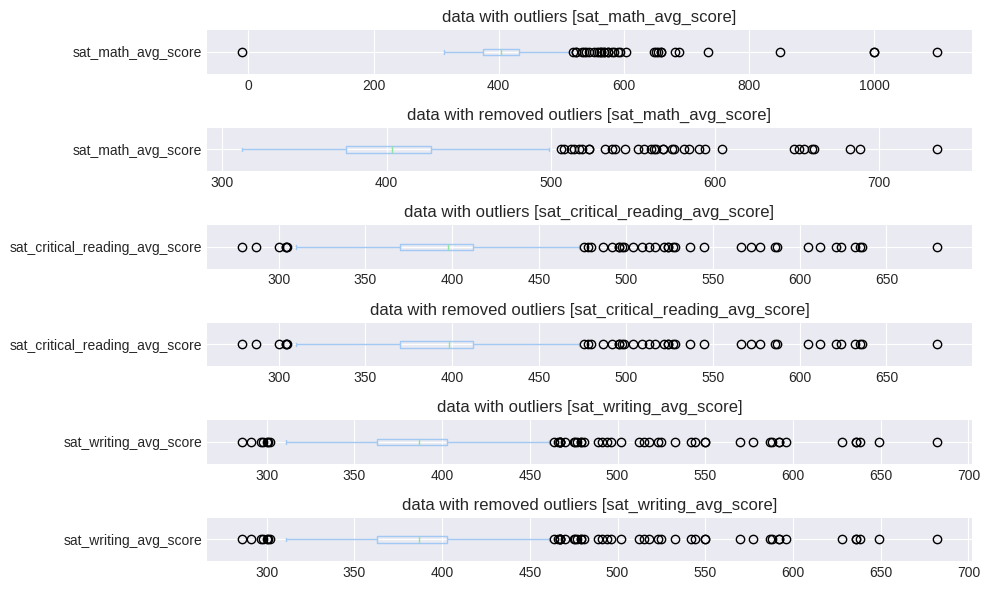

In [288]:
compare_both_boxes(data, test_data, score_cols)

In [289]:
#from the above visualizations, it is clear that removing outliers is ok as it is not affecting the data much
data = test_data.copy()

## contact_extension

<Axes: xlabel='contact_extension'>

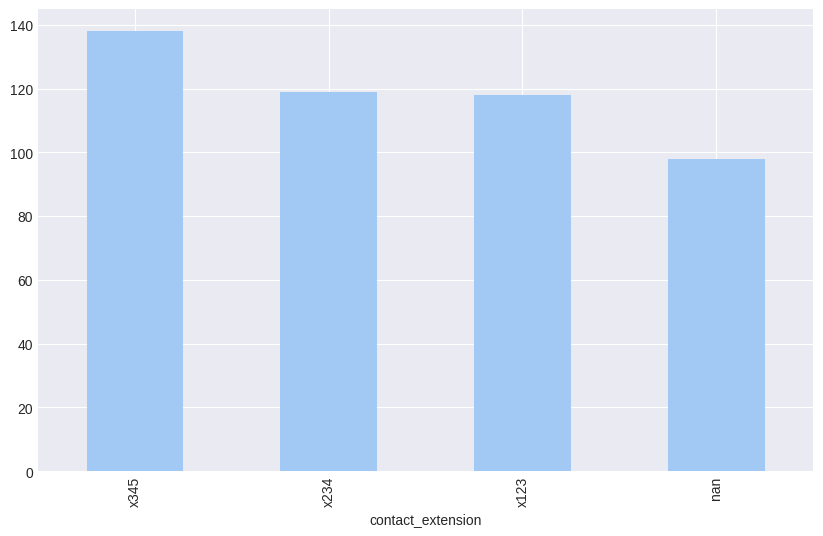

In [290]:
data['contact_extension'].value_counts(dropna=False).plot(kind='bar')

In [291]:
def fill_with_existing_prob(df, col_name, inplace=True, random_state=42):
    """
    Fill null values in a column based on the probability distribution of existing values.

    Parameters:
    - df: DataFrame containing the column
    - col_name: Name of column to impute
    - inplace: Modify the DataFrame directly if True (default), return copy if False
    - random_state: Seed for reproducible results

    Returns:
    - DataFrame with imputed values (if inplace=False)
    """

    if not inplace:
        df = df.copy()

    # Get non-null values and their frequencies
    value_counts = df[col_name].value_counts(normalize=True)

    if len(value_counts) == 0:
        raise ValueError("No non-null values available for sampling")

    # Set random seed
    np.random.seed(random_state)

    # Identify null positions
    null_mask = df[col_name].isna()

    # Sample from existing distribution
    sampled_values = np.random.choice(
        value_counts.index,
        size=null_mask.sum(),
        p=value_counts.values
    )

    # Fill nulls
    df.loc[null_mask, col_name] = sampled_values

    if not inplace:
        return df

In [292]:
fill_with_existing_prob (data, 'contact_extension')

<Axes: xlabel='contact_extension'>

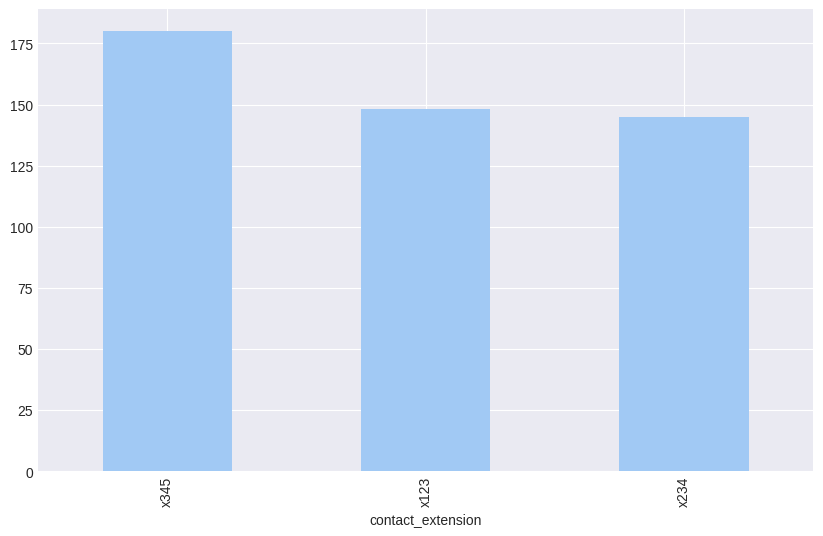

In [293]:
data['contact_extension'].value_counts().plot(kind='bar')

## pct_students_tested

<Axes: xlabel='pct_students_tested'>

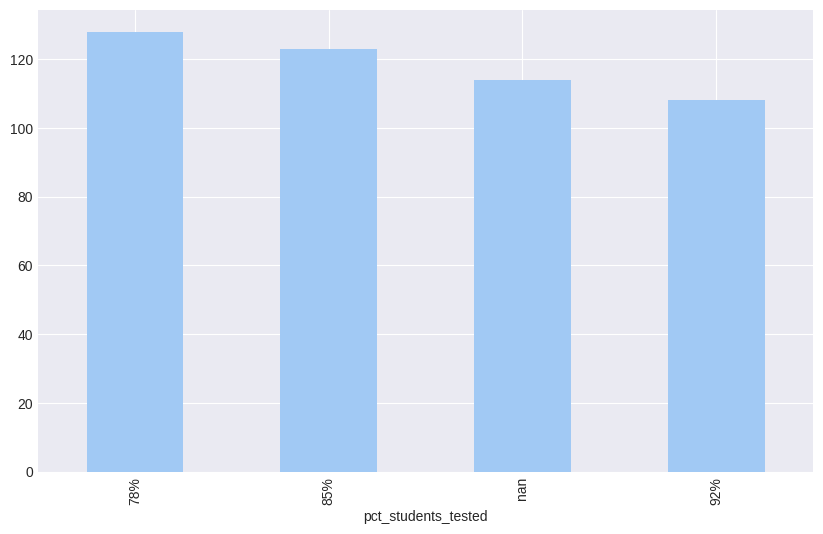

In [294]:
data['pct_students_tested'].value_counts(dropna=False).plot(kind='bar')

In [295]:
fill_with_existing_prob (data, 'pct_students_tested')

<Axes: xlabel='pct_students_tested'>

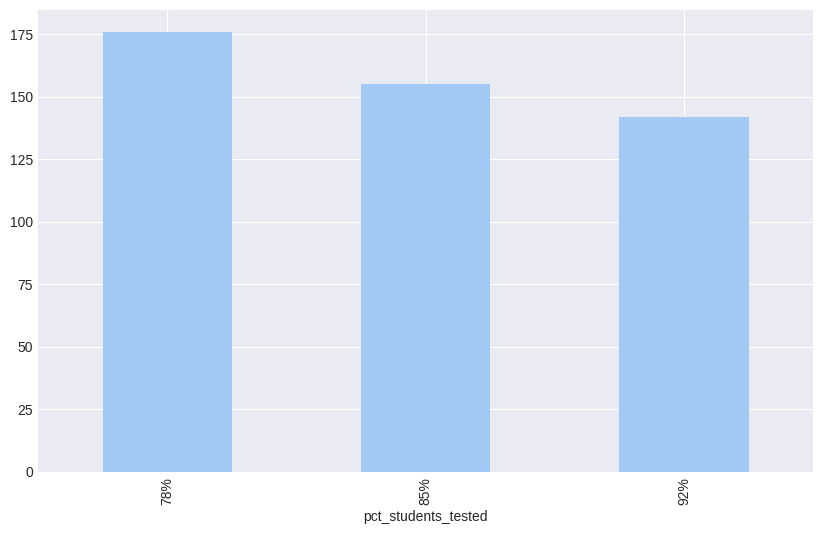

In [296]:
data['pct_students_tested'].value_counts().plot(kind='bar')

In [297]:
data['pct_students_tested'] = data['pct_students_tested'].str.replace('%', '').astype(int)

## academic_tier_rating

<Axes: xlabel='academic_tier_rating'>

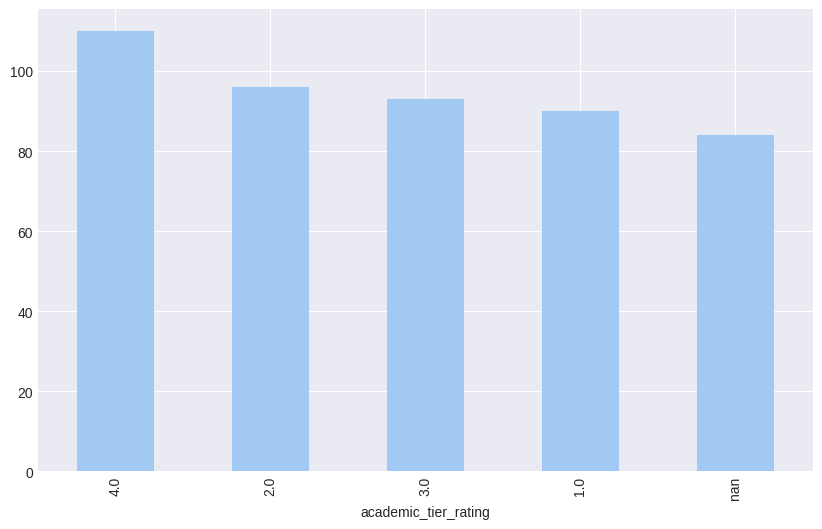

In [298]:
data['academic_tier_rating'].value_counts(dropna=False).plot(kind='bar')

<Axes: xlabel='academic_tier_rating'>

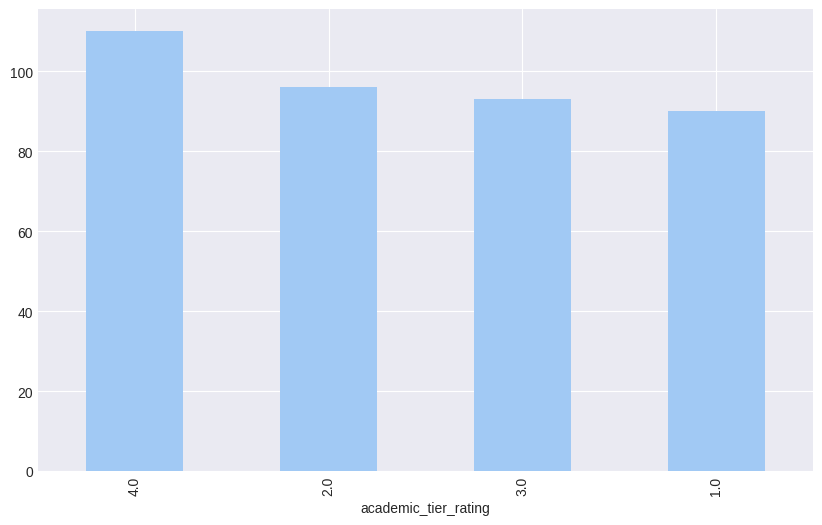

In [299]:
data['academic_tier_rating'].value_counts().plot(kind='bar')

In [300]:
fill_with_existing_prob (data, 'academic_tier_rating')

# Save to cleaned_data.csv

# Upload to Database

In [301]:
import sqlalchemy

DATABASE_URL = (
    "postgresql+psycopg2://neondb_owner:npg_CeS9fJg2azZD"
    "@ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech:5432/neondb"
    "?sslmode=require"
    )


engine = sqlalchemy.create_engine(DATABASE_URL)
data.to_sql(
    name = 'sultan_sat_results',
    con=engine,
    schema='nyc_schools',
    if_exists='replace',
    index=False
)

473

In [302]:
data.to_csv('cleaned_data.csv', index=False)

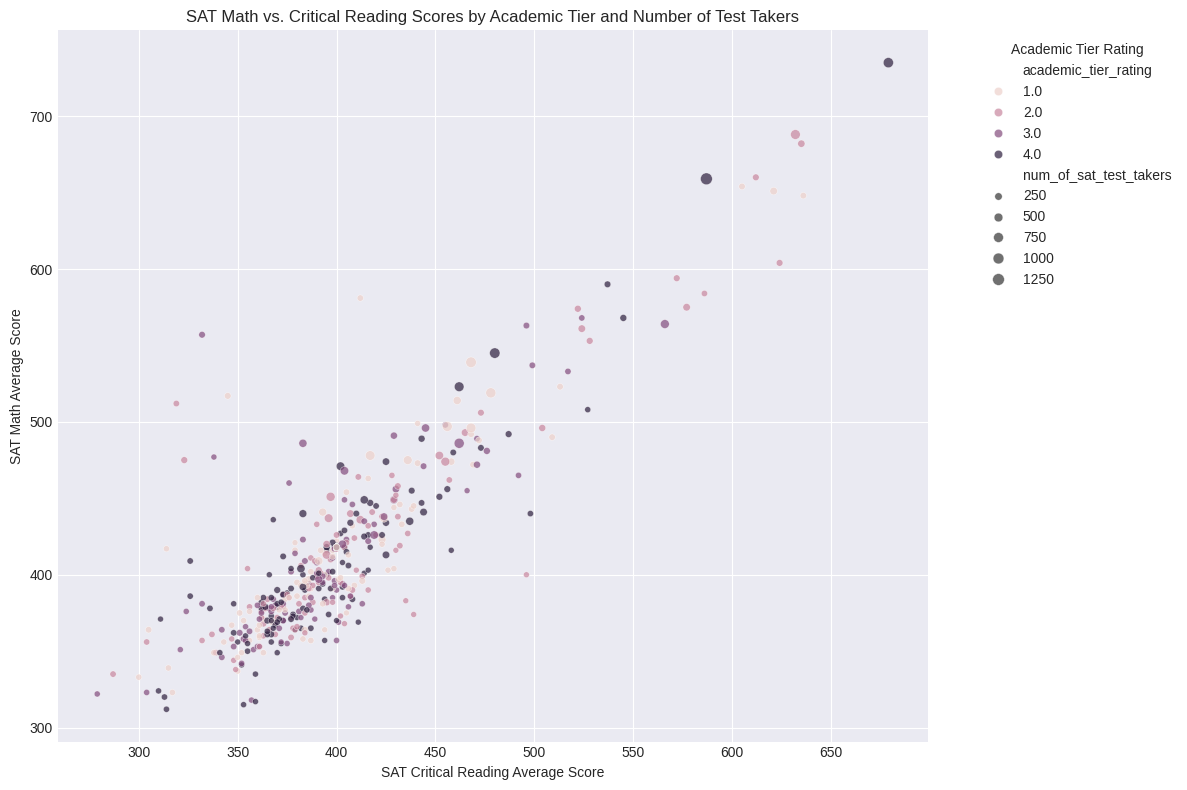

In [303]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data,
                x=data['sat_critical_reading_avg_score'].astype(float),
                y=data['sat_math_avg_score'].astype(float),
                hue='academic_tier_rating',
                size=data['num_of_sat_test_takers'].astype(float),
                alpha=0.7)
plt.title('SAT Math vs. Critical Reading Scores by Academic Tier and Number of Test Takers')
plt.xlabel('SAT Critical Reading Average Score')
plt.ylabel('SAT Math Average Score')
plt.legend(title='Academic Tier Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()